In [1]:
import os
import scanpy as sc
import gc
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from matplotlib.colors import TwoSlopeNorm
import matplotlib as mpl
import gseapy as gp

In [2]:
figpath = '/stanley/WangLab/kamal/figures/projects/manifesto/regions_tonsil_fh/'
os.makedirs(figpath, exist_ok=True)
dpi = 500

# Load

In [3]:
adata = sc.read_h5ad('/stanley/WangLab/kamal/data/technologies/xenium/tonsil_fh/filtered/adata_heat.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 1349474 × 377
    obs: 'transcript_counts', 'n_counts'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'heat'

In [22]:
# Set figure size
width = adata.obsm['spatial'][:,0].ptp()
height = adata.obsm['spatial'][:,1].ptp()
set_width = 10
fignorm = set_width / width
sc.set_figure_params(figsize=(set_width, height*fignorm))
figsize=(set_width, height*fignorm)

In [6]:
filter_key = 'heat'
max_mag = 2

# Scale
sc.pp.scale(adata, layer=filter_key)

# Clip
X = adata.layers[filter_key]
X[X > max_mag] = max_mag
X[X < -max_mag] = -max_mag

# Clustering

In [7]:
n_pcs = 10
pca = PCA(n_components=n_pcs, random_state=0)
adata.obsm['X_pca_heat'] = pca.fit_transform(adata.layers['heat'])
adata.varm['X_pca_heat'] = pca.components_.T

In [8]:
n_regions = 4
kmeans = KMeans(n_clusters=n_regions, random_state=0)
kmeans.fit(adata.obsm['X_pca_heat'])
adata.obs['region'] = kmeans.labels_.astype(str)

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [15]:
regions = sorted(adata.obs['region'].unique())
colors = np.array(sc.pl.palettes.default_28)[[5,0,1,9]]
palette = {region:color for region,color in zip(regions,colors)}
adata.obs['region_color'] = adata.obs['region'].map(palette)

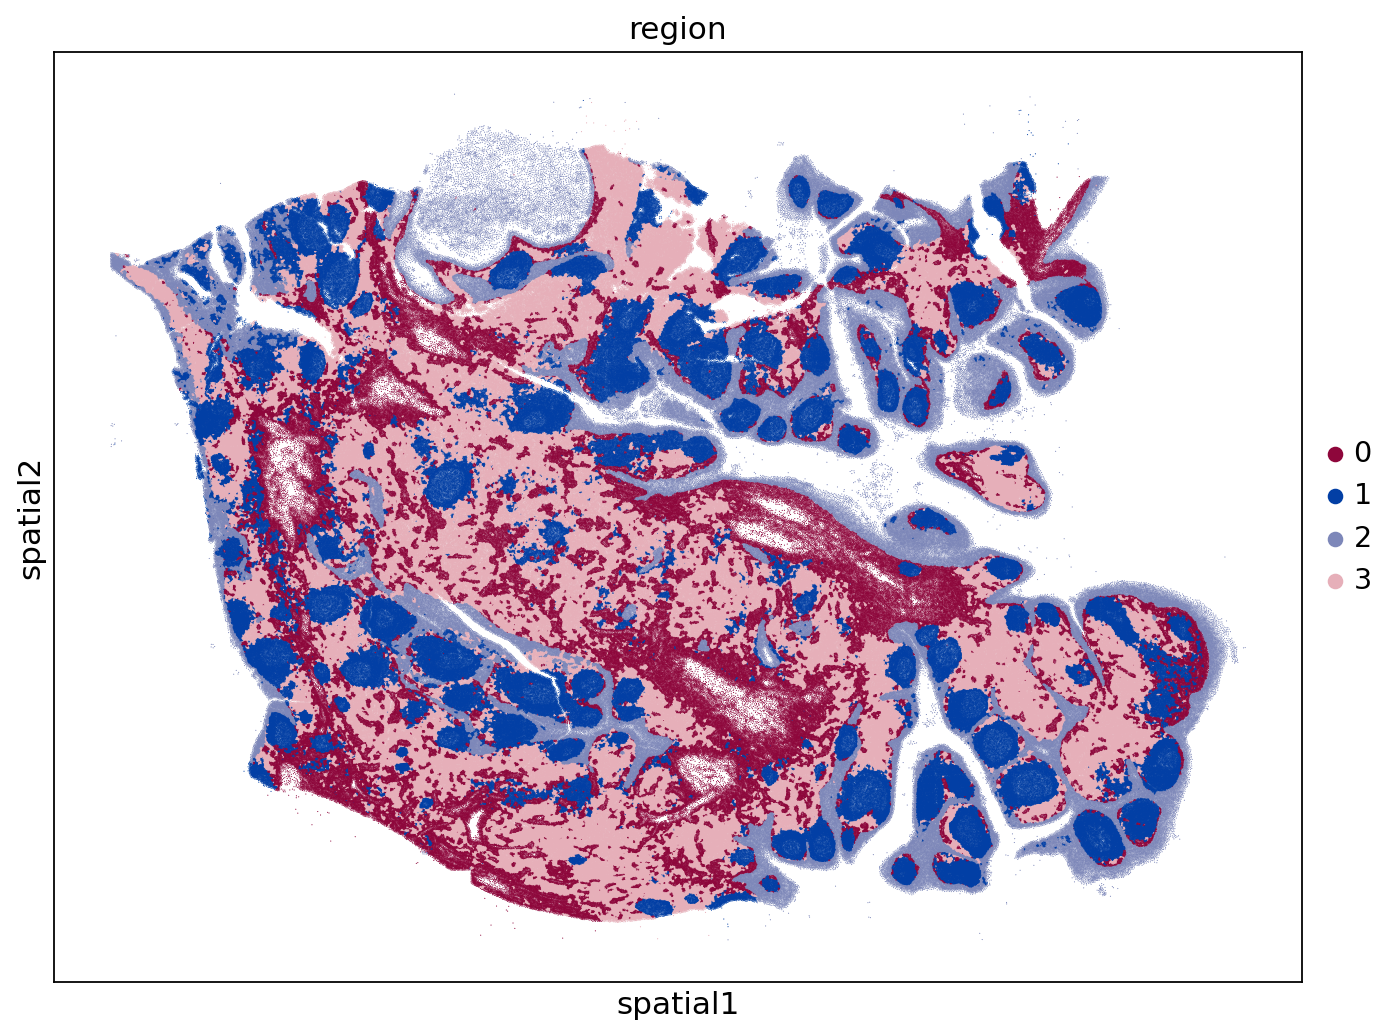

In [16]:
sc.pl.embedding(
    adata,
    basis='spatial',
    color='region',
    palette=palette,
    s=1,
)

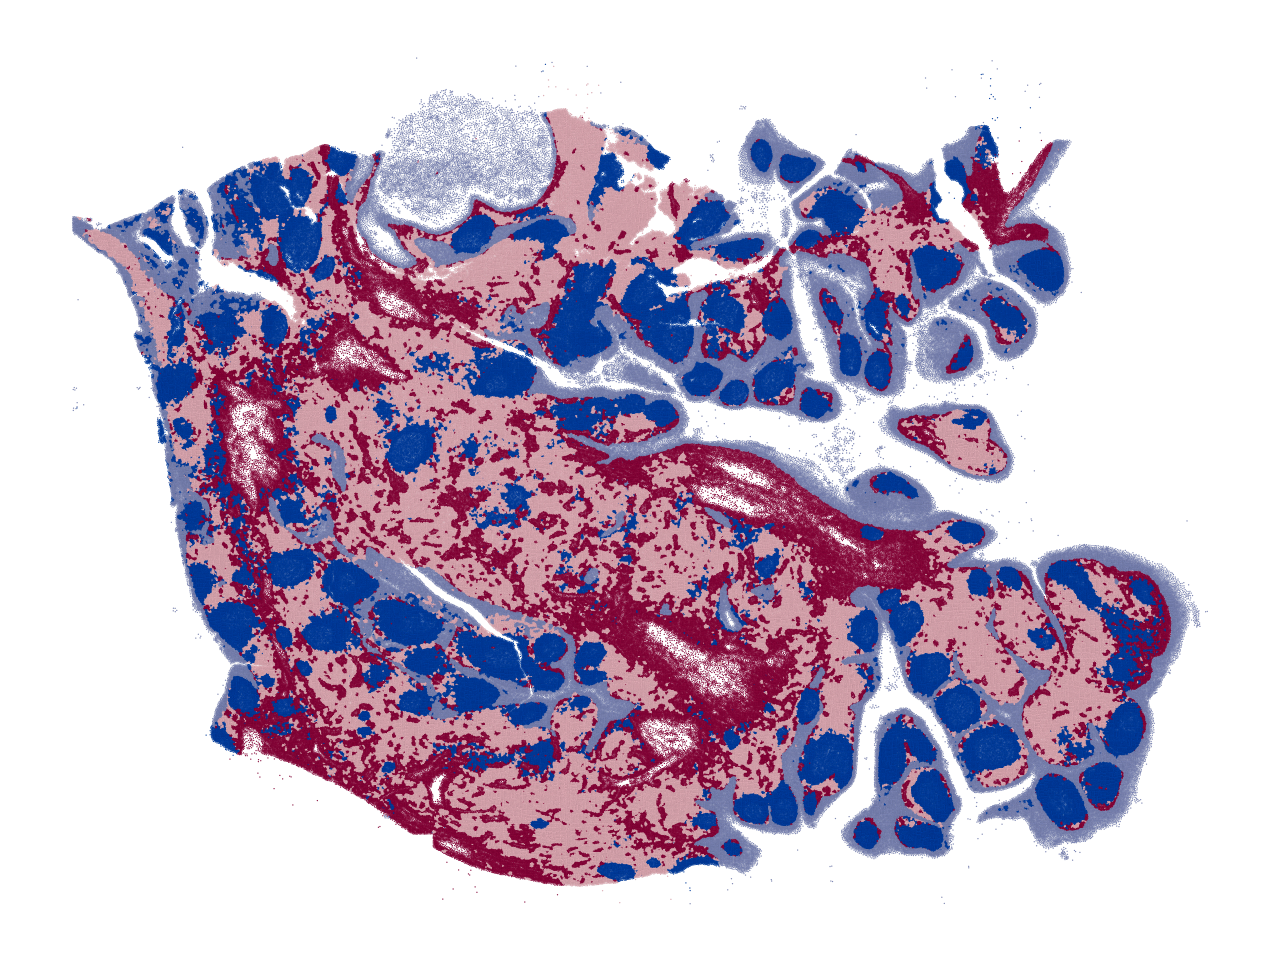

In [17]:
points = adata.obsm['spatial']
plt.figure(figsize=figsize)
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.01,
    s=0.3,
    c=adata.obs['region_color'],
)
plt.axis('off')
filename = os.path.join(figpath, f'regions.png')
plt.savefig(filename, dpi=dpi)
plt.show()

# Plot markers

In [13]:
sc.tl.rank_genes_groups(adata, groupby='region', layer='heat')
sc.tl.dendrogram(adata, groupby='region', use_rep='X_pca_heat')

/home/unix/kmaher/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/unix/kmaher/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/unix/kmaher/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/unix/kmaher/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


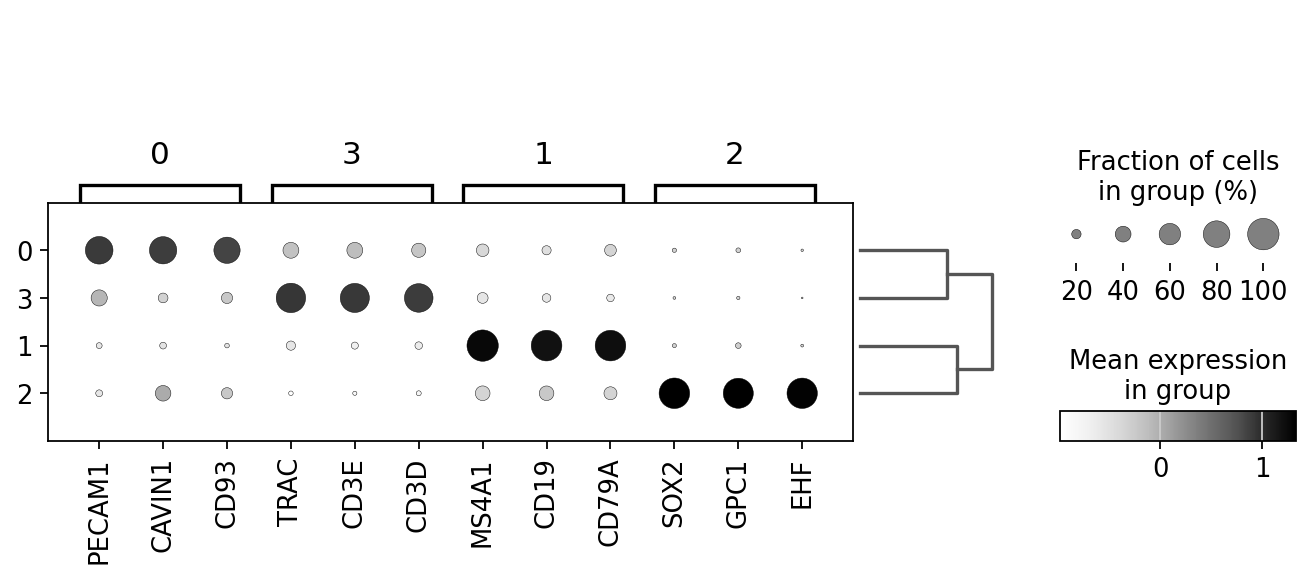

In [14]:
fig = plt.figure(figsize=(10,3.5))
ax = plt.gca()
sc.pl.rank_genes_groups_dotplot(adata, groupby='region', n_genes=3, layer='heat', ax=ax, cmap='Greys')
figname = 'region_markers.png'
savepath = os.path.join(figpath, figname)
fig.savefig(savepath, dpi=dpi, bbox_inches='tight')

One extra region to account for the cancer tissue

# Save region labels to disk

In [35]:
# Save regions to disk
filepath = '/stanley/WangLab/kamal/code/projects/manifesto/figures/tonsil_fh_regions.npy'
np.save(filepath, np.array(adata.obs['region']))

# Zooms

## Matching paracrine PC5

### Zoom 1

In [18]:
# Set zoom dims
width = adata.obsm['spatial'][:,0].ptp()
height = adata.obsm['spatial'][:,1].ptp()
zoom_width = height/8
zoom_height = height/6

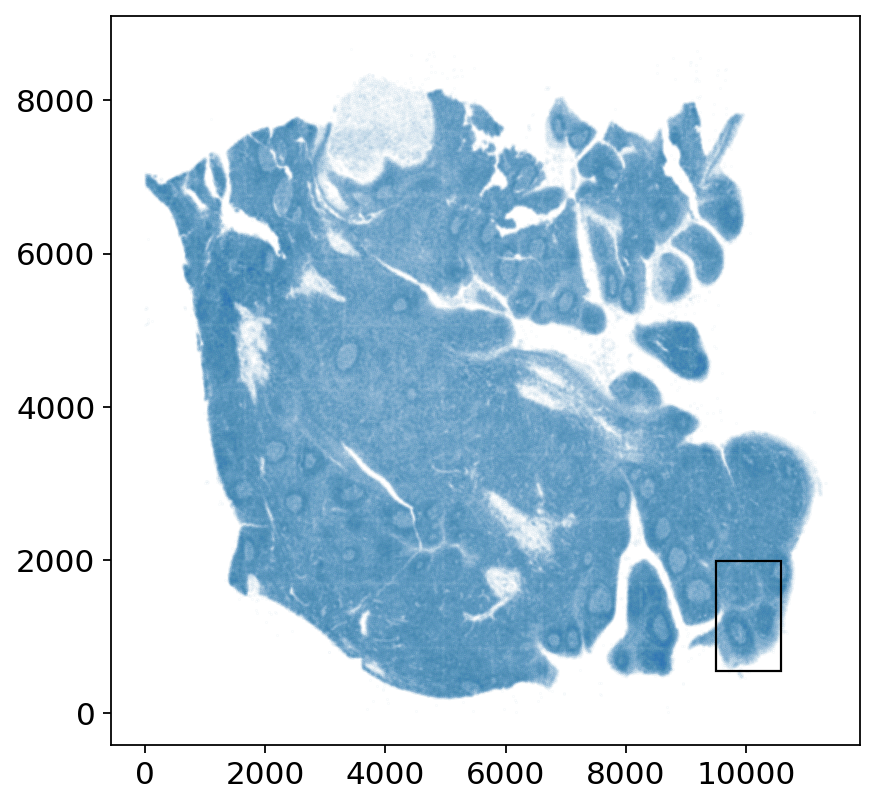

In [19]:
zoom_x = 9500
zoom_y = 550

plt.figure(figsize=(6,6))
plt.scatter(*adata.obsm['spatial'].T, s=0.0001)
rect = mpl.patches.Rectangle((zoom_x, zoom_y), zoom_width, zoom_height, edgecolor='k', fill=False)
plt.gca().add_patch(rect)
plt.grid(None)
plt.show()

In [20]:
zdata = adata[adata.obsm['spatial'][:,0]>zoom_x]
zdata = zdata[zdata.obsm['spatial'][:,0]<zoom_x+zoom_width]
zdata = zdata[zdata.obsm['spatial'][:,1]>zoom_y]
zdata = zdata[zdata.obsm['spatial'][:,1]<zoom_y+zoom_height]

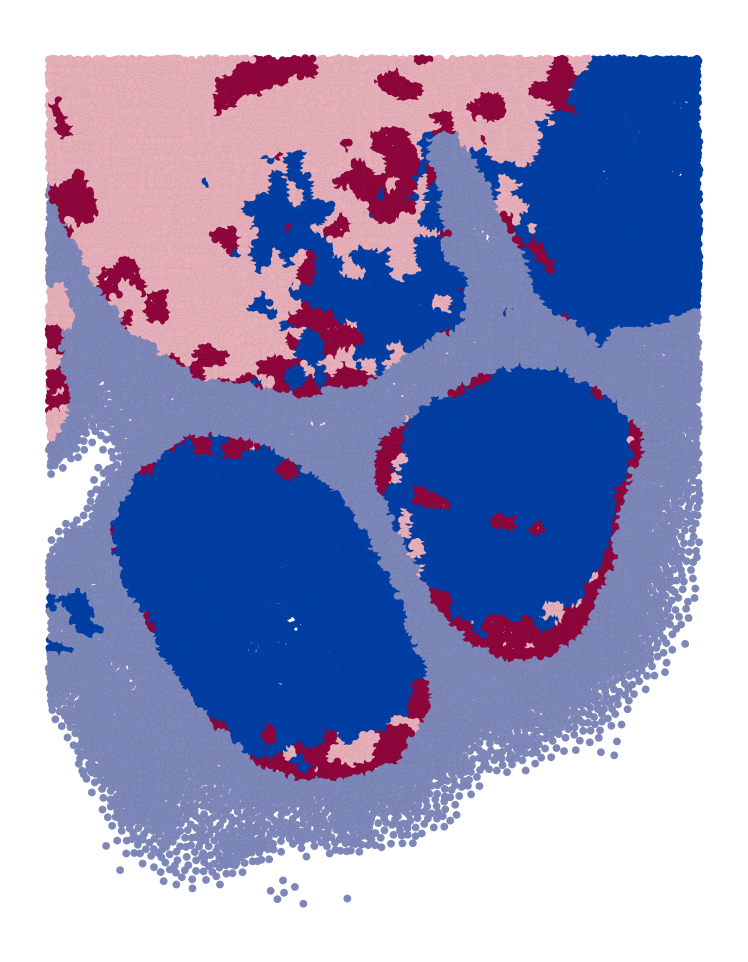

In [23]:
points = zdata.obsm['spatial']
plt.figure(figsize=(height*fignorm*(zoom_width/zoom_height), height*fignorm))
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.01,
    s=12,
    c=zdata.obs['region_color'],
)
plt.axis('off')
filename = os.path.join(figpath, f'region_zoom.png')
plt.savefig(filename, dpi=dpi)
plt.show()